In [198]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


### Dataset Class (loads data from csv)

In [199]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(128100, 8)
(16050, 8)
(16050, 8)


### Dataloader definitions (provides data in iterable form)

In [200]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

# signal, label = next(iter(trainloader))
# print(signal.shape)
# print(label.shape)

Function for calculating output size for given input size, filter size, padding and stride for a CNN

In [201]:
def output_size(n, f, p = 0, s = 1):
    return (((n + 2 * p - f) / s) + 1)

output_size(150, 3)
output_size(148, 3)

146.0

In [107]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
#         self.conv1 = nn.Conv1d(3, 10, 3)
#         self.conv2 = nn.Conv1d(10, 15, 3)
#         self.conv3 = nn.Conv1d(15, 20, 3)
        self.fc1 = nn.Linear(150 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)
        
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc3.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal = signal.view(-1, 150 * 3)
        out = F.relu(self.fc1(signal))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [108]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-1)

In [109]:
num_epochs = 20
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '2conv_softmax.pt')

epoch =  0  step =  0  of total steps  16012  loss =  1.7440937757492065
epoch =  0  step =  20  of total steps  16012  loss =  1.388783574104309
epoch =  0  step =  40  of total steps  16012  loss =  1.5119402408599854
epoch =  0  step =  60  of total steps  16012  loss =  1.497506856918335
epoch =  0  step =  80  of total steps  16012  loss =  1.5476007461547852
epoch =  0  step =  100  of total steps  16012  loss =  1.4727420806884766
epoch :  0  /  20  | TL :  1.5255412245696445  | VL :  1.530864953994751
saving model
epoch =  1  step =  0  of total steps  16012  loss =  1.5372083187103271
epoch =  1  step =  20  of total steps  16012  loss =  1.3468658924102783
epoch =  1  step =  40  of total steps  16012  loss =  1.5341323614120483
epoch =  1  step =  60  of total steps  16012  loss =  1.5024219751358032
epoch =  1  step =  80  of total steps  16012  loss =  1.438321590423584
epoch =  1  step =  100  of total steps  16012  loss =  1.5530476570129395
epoch :  1  /  20  | TL :  1.

epoch =  15  step =  100  of total steps  16012  loss =  1.662811040878296
epoch :  15  /  20  | TL :  1.5143744473187428  | VL :  1.525626540184021
epoch =  16  step =  0  of total steps  16012  loss =  1.6300100088119507
epoch =  16  step =  20  of total steps  16012  loss =  1.3399255275726318
epoch =  16  step =  40  of total steps  16012  loss =  1.5294454097747803
epoch =  16  step =  60  of total steps  16012  loss =  1.5600128173828125
epoch =  16  step =  80  of total steps  16012  loss =  1.3406175374984741
epoch =  16  step =  100  of total steps  16012  loss =  1.3808459043502808
epoch :  16  /  20  | TL :  1.513566330918726  | VL :  1.5290355682373047
epoch =  17  step =  0  of total steps  16012  loss =  1.394396185874939
epoch =  17  step =  20  of total steps  16012  loss =  1.5891327857971191
epoch =  17  step =  40  of total steps  16012  loss =  1.5195121765136719
epoch =  17  step =  60  of total steps  16012  loss =  1.4190921783447266
epoch =  17  step =  80  of t

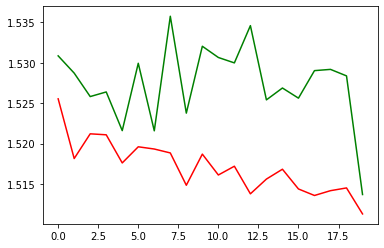

In [110]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [111]:
def _get_accuracy(dataloader):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net.cpu()
# _get_accuracy(trainloader)

ConvNet(
  (fc1): Linear(in_features=450, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [112]:
print(_get_accuracy(trainloader))
print(_get_accuracy(testloader))
print(_get_accuracy(valloader))

0.38207547169811323
0.41346153846153844
0.3557692307692308


#### Directly training NNs on raw data doesn't work well (network overfits most of the time). So, we can try to use some pre-processing to the data before training (like running mean, running std deviation, running rms, etc.)

### Processing Functions

In [202]:
def running_mean(signal, window_size = 10):
    ''' Returns running mean of 3D signal (batch_size, length, channels)
    '''
    mean = torch.zeros_like(signal)
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size) : 
            mean[i][j] = signal[i][j : j + window_size].mean(dim = 0)
            
    for i in range(signal.shape[0]) :
        for j in range(signal.shape[1] - window_size, signal.shape[1]) :
            mean[i][j] = signal[i][j]
            
    return mean

### Shows working of `running_mean` function

torch.Size([8, 150, 3])


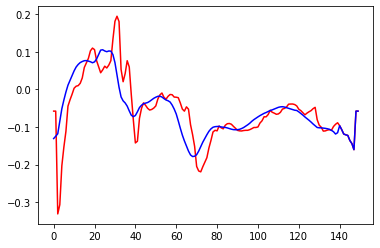

In [203]:
signal, label = next(iter(trainloader))
# print(signal.shape)
# print(signal[2].shape)
# print(signal[2].mean(dim = 0).shape)
# print(signal[2][ : 10].mean(dim = 0).shape)
# print(signal[1][2].shape)
mean = running_mean(signal)
print(mean.shape)
sig_ = signal[0].transpose(0, 1)
mean_ = mean[0].transpose(0, 1)
t = range(150)
plt.plot(t, sig_[0].data.numpy(), 'r', t, mean_[0].data.numpy(), 'b')

### Training network using `running_mean` processed data

In [286]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 5, 3)
        self.fc1 = nn.Linear(148 * 5, 5)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal_ = running_mean(signal, window_size = 30)
        signal_ = signal_.view(-1, 3, 150)
        out = F.relu(self.conv1(signal_))
        out = out.view(-1, 148 * 5)
        out = F.log_softmax(self.fc1(out), dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [287]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3, weight_decay = 1e-3)

In [288]:
num_epochs = 20
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '2fc_softmax.pt')

epoch =  0  step =  0  of total steps  106  loss =  1.5879511833190918
epoch =  0  step =  20  of total steps  106  loss =  1.510141372680664
epoch =  0  step =  40  of total steps  106  loss =  1.3134374618530273
epoch =  0  step =  60  of total steps  106  loss =  1.8948047161102295
epoch =  0  step =  80  of total steps  106  loss =  1.4915242195129395
epoch =  0  step =  100  of total steps  106  loss =  1.536300539970398
epoch :  0  /  20  | TL :  1.533472553739008  | VL :  1.5684475898742676
saving model
epoch =  1  step =  0  of total steps  106  loss =  1.5454784631729126
epoch =  1  step =  20  of total steps  106  loss =  1.41603422164917
epoch =  1  step =  40  of total steps  106  loss =  1.5057374238967896
epoch =  1  step =  60  of total steps  106  loss =  2.0736308097839355
epoch =  1  step =  80  of total steps  106  loss =  1.8176738023757935
epoch =  1  step =  100  of total steps  106  loss =  1.6216012239456177
epoch :  1  /  20  | TL :  1.491340992585668  | VL :  

epoch =  16  step =  20  of total steps  106  loss =  1.321864128112793
epoch =  16  step =  40  of total steps  106  loss =  1.4162280559539795
epoch =  16  step =  60  of total steps  106  loss =  1.4858487844467163
epoch =  16  step =  80  of total steps  106  loss =  1.5739853382110596
epoch =  16  step =  100  of total steps  106  loss =  1.1646418571472168
epoch :  16  /  20  | TL :  1.3223287232641905  | VL :  1.5427696704864502
epoch =  17  step =  0  of total steps  106  loss =  1.3406345844268799
epoch =  17  step =  20  of total steps  106  loss =  1.3882519006729126
epoch =  17  step =  40  of total steps  106  loss =  1.0848888158798218
epoch =  17  step =  60  of total steps  106  loss =  0.8983068466186523
epoch =  17  step =  80  of total steps  106  loss =  1.4485406875610352
epoch =  17  step =  100  of total steps  106  loss =  1.1332603693008423
epoch :  17  /  20  | TL :  1.3113673419322607  | VL :  1.5257456302642822
epoch =  18  step =  0  of total steps  106  lo

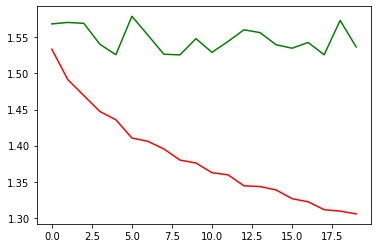

In [289]:
j = np.arange(20)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [290]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [291]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.4716981132075472
0.3942307692307692
0.34615384615384615


In [292]:
testing_Net = ConvNet()
testing_Net.load_state_dict(torch.load('2fc_softmax.pt'))
testing_Net.eval()
print(_get_accuracy(trainloader, testing_Net))
print(_get_accuracy(testloader, testing_Net))
print(_get_accuracy(valloader, testing_Net))

0.44575471698113206
0.40384615384615385
0.3076923076923077


#### Even using `running_mean` processed data, the network again overfits. Even increasing window size didn't help (decreasing won't help as it will be closer to raw data then). Increasing too much is also not helpful as the plot will get more and more flat. So, we need to try out other features.